# $ P(x) = \int P(x,t) P(t) dt $

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd


In [2]:
N_sim = int(1e5)
dt = 1e-3
T_max = 2
dB = np.sqrt(dt)

DV_vs_t = np.zeros((N_sim, int(T_max/dt)))


v = 1; a = 2
for n in tqdm(range(N_sim)):
    t = 0
    DV = 0
    for i in range(1,int(T_max/dt)):
        t += dt
        DV += v*dt + np.random.normal(0, dB)
        DV_vs_t[n, int(t/dt)] = DV
        if DV >= a:
            break
        

# from multiprocessing import Pool
# from tqdm import tqdm


# Pre-allocate the array to store results

# def simulate(n):
#     t = 0
#     DV = 0
#     DV_vs_t_n = np.zeros(int(T_max / dt) + 1)
#     for i in range(1, int(T_max / dt)):
#         t += dt
#         DV += v * dt + np.random.normal(0, dB)
#         DV_vs_t_n[int(t / dt)] = DV
#         if DV >= a:
#             break
#     return DV_vs_t_n

# with Pool(processes=64) as pool:
#     results = list(tqdm(pool.imap(simulate, range(N_sim)), total=N_sim))

# DV_vs_t = np.array(results)

        

100%|██████████| 100000/100000 [01:21<00:00, 1223.26it/s]


# $ P(x,t) $

In [30]:
def theory_curve(x,t,v,a):
    return (1/np.sqrt(2 * (np.pi**2) * t)) * \
        ( np.exp(-((x - v*t)**2)/(2*t)) - np.exp( 2*v*a - ((x - 2*a - v*t)**2)/(2*t) ) )

In [31]:
area = quad(theory_curve, -2, 2, args=(t,v,a))[0]
print(area)
t = 0.05
t_bin = int(t/dt)


0.5641895835477564


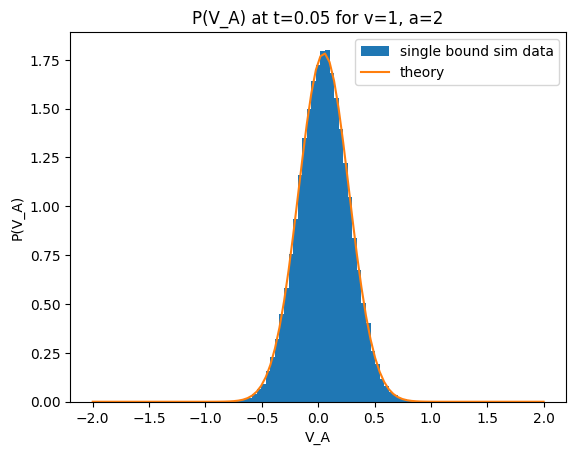

In [33]:
P_x_at_t = DV_vs_t[:,t_bin]
plt.hist(P_x_at_t, bins=np.linspace(-2,2,100), density=True, label='single bound sim data');

x_pts = np.linspace(-2, 2, 100)
v = 1; a = 2
theory = [theory_curve(x, t, v, a)/area for x in x_pts]
plt.plot(x_pts, theory, label='theory')

plt.xlabel('V_A')
plt.ylabel('P(V_A)')
plt.title(f'P(V_A) at t={t} for v={v}, a={a}')
plt.legend()


# find $P(t)$

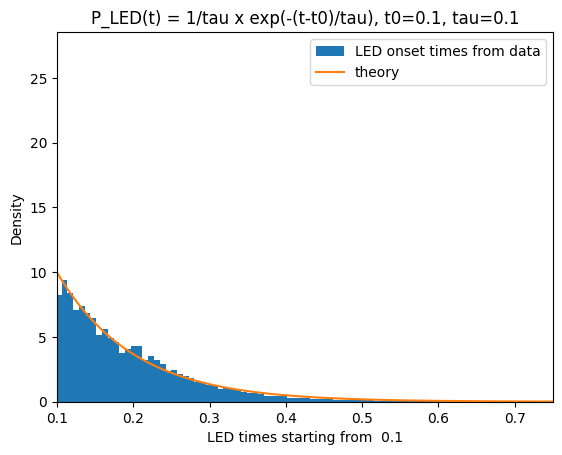

In [27]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')
# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ].copy()

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

LED_on_times = df['LED_onset_time'].values

t_pts = np.linspace(0, 0.75, 100)
plt.hist(LED_on_times, bins=t_pts, density=True, label='LED onset times from data');
tau = 0.1; t0 = 0.1
plt.plot(t_pts, np.exp(-(t_pts - t0)/tau)/tau, label='theory')
plt.xlim([t0, 0.75])
plt.xlabel(f'LED times starting from  {t0}');
plt.ylabel('Density');
plt.title(f'P_LED(t) = 1/tau x exp(-(t-t0)/tau), t0={t0}, tau={tau}');
plt.legend()

# $ \int P(x,t) P(t)$ from 0.2 to np.inf

In [13]:
# Params


def P_t_x(t,x,v,a):
    return (1/np.sqrt(2 * (np.pi**2) * t)) * \
        ( np.exp(-((x - v*t)**2)/(2*t)) - np.exp( 2*v*a - ((x - 2*a - v*t)**2)/(2*t) ) )

def P_t(t):
    tau = 0.1; t0 = 0.1
    return np.exp(-(t - t0)/tau)/tau


def P_t_x_times_P_t(t, x, v, a):
    return P_t(t) * P_t_x(t, x, v, a)


def P_x(x,v,a):
    return quad(P_t_x_times_P_t, t0, 5, args=(x,v,a))[0]

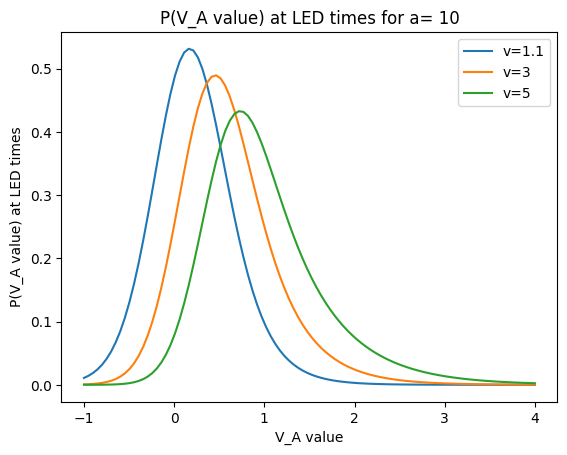

In [20]:
x_pts = np.linspace(-1, 4, 100)
v_pts = [1.1, 3, 5]
a = 10
for v in v_pts:
    P_x_theory = [P_x(x,v,a) for x in x_pts]
    plt.plot(x_pts, P_x_theory, label=f'v={v}')
plt.xlabel('V_A value')
plt.ylabel('P(V_A value) at LED times')
plt.title(f'P(V_A value) at LED times for a= {a}')
plt.legend();

## 